In [2]:
import requests
import json
from category import Category
from database import Database
from playlist import Playlist
from track import Track
from artist import Artist
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [146]:
db = Database()
playlists = Playlist.loadAll(db)

### EDA of Music Genres

In [149]:
genre_counts = {}     # Track counts of all genres
genre_track_mean = {} # Average track length for each genre
genre_explicit_mean  = {}  #
for playlist in playlists:
    for track in playlist.tracks:
        if track.artist1 and track.artist1.genres:
            for genre in track.artist1.genres:
                genre = genre.replace(" ", "_")
                #print (genre)
                if genre:
                    if genre in genre_counts.keys():
                        genre_counts[genre] += 1
                        genre_track_mean[genre] = genre_track_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.duration/genre_counts[genre]
                        genre_explicit_mean[genre] = genre_explicit_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.explicit/genre_counts[genre]
                    else:
                        genre_counts[genre] = 1
                        genre_track_mean[genre] = track.duration
                        genre_explicit_mean[genre] = track.explicit
        if track.artist2 and track.artist2.genres:
            for genre in track.artist2.genres:
                genre = genre.replace(" ", "_")
                if genre:
                    if genre in genre_counts.keys():
                        genre_counts[genre] += 1
                        genre_track_mean[genre] = genre_track_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.duration/genre_counts[genre]
                        genre_explicit_mean[genre] = genre_explicit_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.explicit/genre_counts[genre]
                    else:
                        genre_counts[genre] = 1
                        genre_track_mean[genre] = track.duration
                        genre_explicit_mean[genre] = track.explicit
        if track.artist3 and track.artist3.genres:
            for genre in track.artist3.genres:
                genre = genre.replace(" ", "_")
                if genre:
                    if genre in genre_counts.keys():
                        genre_counts[genre] += 1
                        genre_track_mean[genre] = genre_track_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.duration/genre_counts[genre]
                        genre_explicit_mean[genre] = genre_explicit_mean[genre]*(genre_counts[genre] - 1)/genre_counts[genre] \
                        + track.explicit/genre_counts[genre]
                    else:
                        genre_counts[genre] = 1
                        genre_track_mean[genre] = track.duration
                        genre_explicit_mean[genre] = track.explicit
#s = [(k, genre_counts[k]) for k in sorted(genre_counts, key=genre_counts.get, reverse=True)]
#for k, v in s:
#    print (str(k) + "," + str(v))

In [150]:
# Create genre dataframe containing genre specific statistics and write to file
df_genre_counts = pd.DataFrame()
df_genre_counts['Genre'] = genre_counts.keys()
df_genre_counts['Track_Counts'] = genre_counts.values()
df_genre_counts.to_csv('genre_counts.csv', index=False)
df_genre_track = pd.DataFrame()
df_genre_track['Genre'] = genre_track_mean.keys()
df_genre_track['Mean_Track_Length'] = genre_track_mean.values()
df_genre_explicit = pd.DataFrame()
df_genre_explicit['Genre'] = genre_explicit_mean.keys()
df_genre_explicit['Mean_Explicit'] = genre_explicit_mean.values()
df_genres = pd.merge(df_genre_counts, df_genre_track, on = 'Genre')
df_genres = pd.merge(df_genres, df_genre_explicit, on = 'Genre')

In [151]:
df_genres.head()

,Genre,Track_Counts,Mean_Track_Length,Mean_Explicit
0,pop_rap,8476,242570.661515,0.557102
1,alternative_dance,1765,251179.044193,0.035694
2,dance_pop,11296,231081.140846,0.180241
3,escape_room,1024,229862.386719,0.295898
4,indie_r&b,3483,241377.682171,0.223658


In [211]:
df_genres.describe()

,Track_Counts,Mean_Track_Length,Mean_Explicit
count,1364.000000,1.364000e+03,1364.000000
mean,371.389296,2.728410e+05,0.058946
std,1021.207629,1.353778e+05,0.159817
min,1.000000,5.048147e+04,0.000000
25%,5.750000,2.171917e+05,0.000000
50%,33.000000,2.419258e+05,0.000000
75%,246.000000,2.872807e+05,0.033457
max,13951.000000,2.195653e+06,1.000000


In [213]:
df_genres[result.Genre == 'skiffle']

,Genre,Track_Counts,Mean_Track_Length,Mean_Explicit
1309,skiffle,1,290693.0,0.0


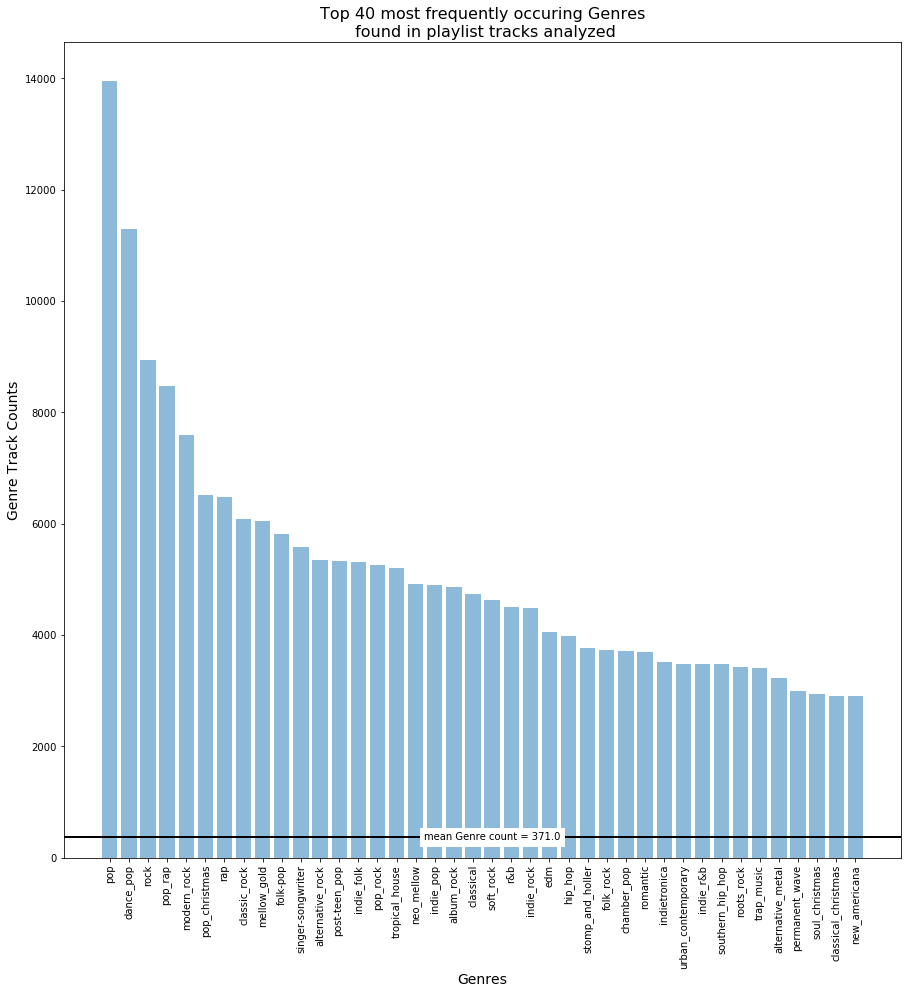

In [206]:
# EDA - Visualize Genres with most the most number of tracks tagged with that Genre
df_genres_sorted = df_genres.sort_values('Track_Counts',ascending=False)
asd = df_genres_sorted.head(n=40)
mean_genre = np.round(np.mean(df_genres.Track_Counts))
objects  = tuple(list(asd['Genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['Track_Counts'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.Track_Counts), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.Track_Counts), 'mean Genre count = '+str(mean_genre), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most frequently occuring Genres\n found in playlist tracks analyzed", fontsize = 16)
plt.ylabel("Genre Track Counts", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)


####  Which Genres have the most Track counts?

Examining all tracks in all the playlists, we plot the top 40 Genres with the most Track counts.  The most frequently occuring Genres in the playlists are generalized Genres of current, popular music such as 'pop', 'rock' and 'rap' and combinations of these general Genres ('pop rap', 'pop rock') vs Genres representing a very specific music niche, such as 'skiffle'.

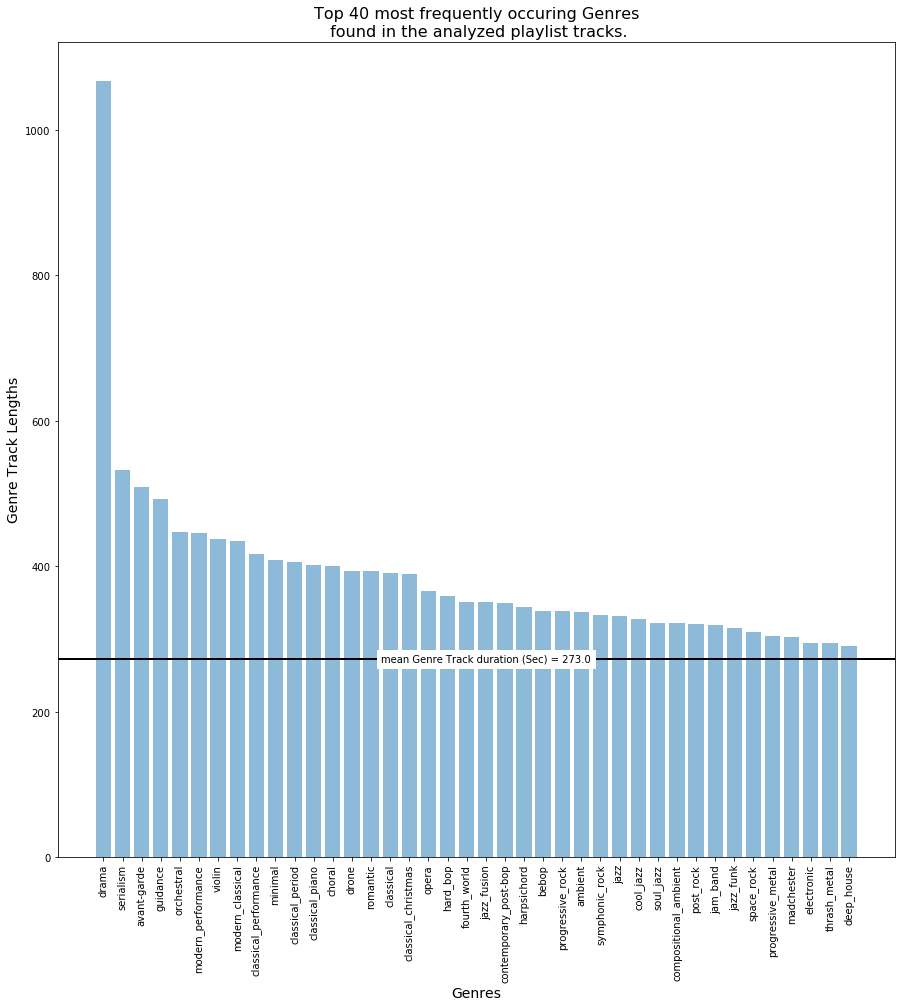

In [225]:
# EDA - Visualize Genres track lengths
df_genres_sorted = df_genres.sort_values('Mean_Track_Length',ascending=False)
asd = df_genres[df_genres['Track_Counts'] > 371].sort_values('Mean_Track_Length',ascending=False).head(n=40)
mean_duration = np.round(np.mean(df_genres.Mean_Track_Length)/1000.0)
objects  = tuple(list(asd['Genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['Mean_Track_Length']/1000.0)
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = mean_duration, linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.Mean_Track_Length)/1000.0, 'mean Genre Track duration (Sec) = '+str(mean_duration), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most frequently occuring Genres\n found in the analyzed playlist tracks.", fontsize = 16)
plt.ylabel("Genre Track Lengths", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)

####  Which Genres have longer duration Track?

We plotted the top 40 Genres with the longest average track length (in seconds), considering only Genres having a significant Track count, where significant is defined as a Genre having the mean number of Tracks (371) or more associated with it. This amounts to considering 266 Genres. <br>

The average Track length is ~4.5 minutes. Classical and Jazz related Genres dominate the bar chart.

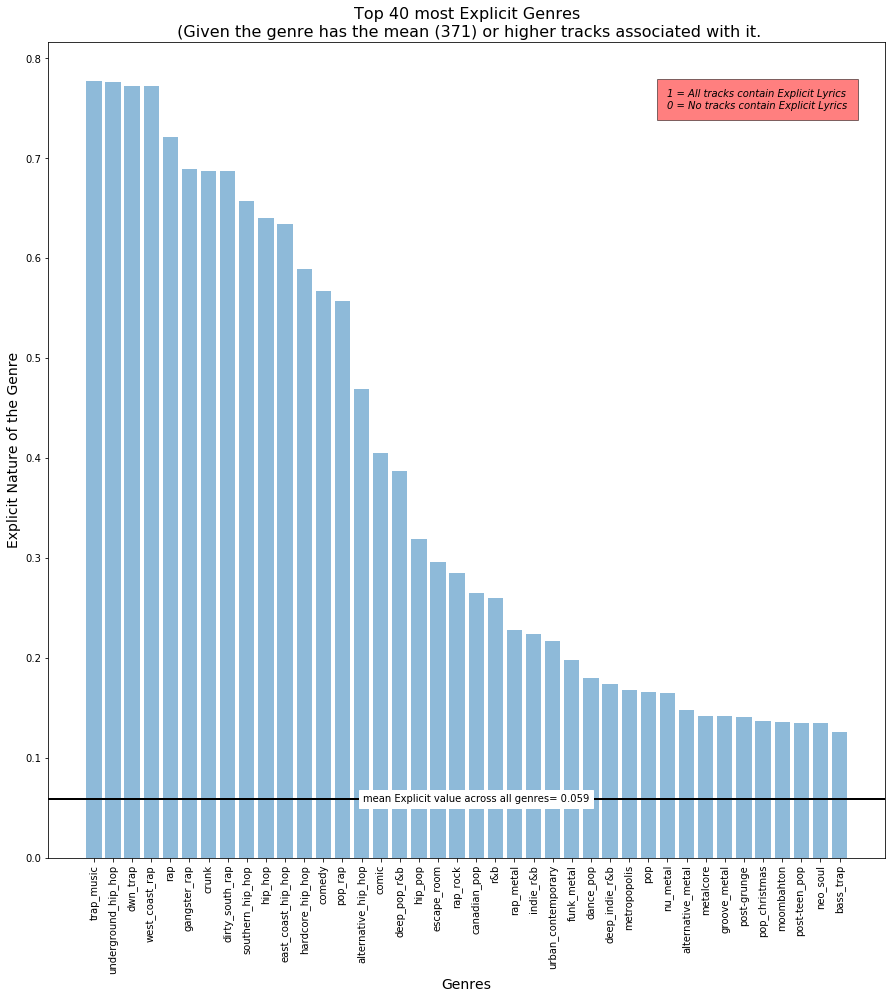

In [229]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['Track_Counts'] > 371].sort_values('Mean_Explicit',ascending=False).head(n=40)
mean_explicit = np.around(np.mean(df_genres.Mean_Explicit), decimals = 3)
objects  = tuple(list(asd['Genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['Mean_Explicit'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.Mean_Explicit), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.Mean_Explicit), 'mean Explicit value across all genres= '+str(mean_explicit), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most Explicit Genres\n (Given the genre has the mean (371) or higher tracks associated with it.",  
          fontsize = 16)
plt.ylabel("Explicit Nature of the Genre", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.text(30, 0.75, '1 = All tracks contain Explicit Lyrics\n0 = No tracks contain Explicit Lyrics', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

####  Which Genres have more Explicit lyrics on average?  

We plotted the top 40 most Explicit Genres, considering only the Genres having a significant Track count, where significant is defined as a Genre having the mean number of Tracks (371) or more associated with it. =

#### Are there any trends where similar genres have more explicit lyrics on average?  

In general, most Genre associated Tracks don't have Explicit lyrics, the average value being 0.059 (closer to 0).  'rap' and 'hip hop' (two closely related Genres) dominate the 20 positions with significantly larger 'Explicit' values than most genres.  Two comedy related genres also appear in the top 20.

### EDA of Playlists

In [239]:
# Create features
artistFollowersList = []
artistPopularityList = []
artistViewsList = []
playlistFollowersList = []
playlistNameList = []
tracksPopularityList = []
trackCountsList = []
trackExplicitList = []
trackDurationList = []
for playlist in playlists:
    artistFollowers = []
    artistPopularity = []
    artistViews = []
    trackPopularity = []
    trackCounts = 0
    trackDuration = []
    trackExplicit = []
    for track in playlist.tracks:
        trackCounts += 1
        trackPopularity.append(track.popularity)
        trackDuration.append(track.duration)
        trackExplicit.append(track.explicit)
        if track.artist1:
            artistFollowers.append(track.artist1.followers)
            artistPopularity.append(track.artist1.popularity)
            artistViews.append(track.artist1.views)
        if track.artist2:
            artistFollowers.append(track.artist2.followers)
            artistViews.append(track.artist2.views)
            artistPopularity.append(track.artist2.popularity)
        if track.artist3:
            artistFollowers.append(track.artist3.followers)
            artistPopularity.append(track.artist3.popularity)
            artistViews.append(track.artist3.views)
    trackCountsList.append(trackCounts)
    trackDurationList.append(np.mean(trackDuration))
    trackExplicitList.append(np.mean(trackExplicit))
    tracksPopularityList.append(np.mean(track.popularity))
    artistFollowersList.append(np.mean(artistFollowers))
    artistViewsList.append(np.mean(artistViews))
    artistPopularityList.append(np.mean(artistPopularity))
    playlistFollowersList.append(playlist.followers)
    playlistNameList.append(playlist.name)

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [244]:
# Create data frame
df_spotify = pd.DataFrame(list(zip(playlistNameList, trackCountsList, trackDurationList, 
                                   artistViewsList, artistPopularityList, tracksPopularityList,
                                   trackExplicitList, artistFollowersList, playlistFollowersList)),
                                   columns=['Playlist_Name', 'Track_Counts', 'Ave_Track_Duration', 
                                            'Ave_Artist_Views', 'Ave_Artist_Popularity',
                                            'Ave_Track_Popularity', 'Ave_Explicit', 'Ave_Followers', 
                                            'Playlist_Followers'])

In [245]:
list(df_spotify)

['Playlist_Name',
 'Track_Counts',
 'Ave_Track_Duration',
 'Ave_Artist_Views',
 'Ave_Artist_Popularity',
 'Ave_Track_Popularity',
 'Ave_Explicit',
 'Ave_Followers',
 'Playlist_Followers']

In [246]:
df_spotify.head()

,Playlist_Name,Track_Counts,Ave_Track_Duration,Ave_Artist_Views,Ave_Artist_Popularity,Ave_Track_Popularity,Ave_Explicit,Ave_Followers,Playlist_Followers
0,b'The Refugee Playlist',22,227756.227273,6.641898e+05,61.848485,62.0,0.090909,5.641147e+05,16084
1,b'This Is: Jason Isbell',49,249611.775510,3.875556e+05,61.140351,35.0,0.000000,7.562475e+04,11378
2,b'This Is: Disney',58,161395.431034,2.773032e+06,60.969072,54.0,0.000000,3.855320e+05,249444
3,b'This Is: The Doors',50,255543.400000,2.265511e+06,75.636364,46.0,0.020000,1.798787e+06,83112
4,b'This Is: AC/DC',35,249849.600000,7.326500e+04,86.000000,58.0,0.000000,4.615190e+06,523790


In [247]:
df_spotify.describe()

,Track_Counts,Ave_Track_Duration,Ave_Artist_Views,Ave_Artist_Popularity,Ave_Track_Popularity,Ave_Explicit,Ave_Followers,Playlist_Followers
count,1605.000000,1.602000e+03,1.602000e+03,1602.000000,1605.000000,1602.000000,1.602000e+03,1.605000e+03
mean,52.000623,2.654270e+05,1.318236e+06,59.961758,35.158255,0.090946,8.848399e+05,1.906739e+05
std,25.085428,1.666180e+05,1.676774e+06,16.817055,23.244791,0.184448,1.273663e+06,4.758098e+05
min,0.000000,3.962875e+04,0.000000e+00,0.000000,0.000000,0.000000,9.000000e+00,0.000000e+00
25%,31.000000,2.150431e+05,2.145605e+05,49.920665,15.000000,0.000000,8.978225e+04,1.823000e+03
50%,50.000000,2.333237e+05,7.174370e+05,60.978207,36.000000,0.010000,3.771229e+05,3.289200e+04
75%,65.000000,2.582519e+05,1.875505e+06,72.400000,53.000000,0.090909,1.150530e+06,1.660340e+05
max,100.000000,2.507284e+06,2.166560e+07,97.166667,97.000000,1.000000,1.312318e+07,1.108252e+07


In [248]:
# Correlation heatmap
import seaborn as sns

#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use Xtrain which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df_spotify.corr() 

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Track_Counts,Ave_Track_Duration,Ave_Artist_Views,Ave_Artist_Popularity,Ave_Track_Popularity,Ave_Explicit,Ave_Followers,Playlist_Followers
Track_Counts,1,0.061,-0.11,-0.14,0.013,-0.069,-0.14,0.2
Ave_Track_Duration,0.061,1,-0.07,-0.32,-0.21,-0.095,-0.12,-0.07
Ave_Artist_Views,-0.11,-0.07,1,0.59,0.25,0.25,0.76,0.099
Ave_Artist_Popularity,-0.14,-0.32,0.59,1,0.53,0.35,0.69,0.22
Ave_Track_Popularity,0.013,-0.21,0.25,0.53,1,0.21,0.35,0.28
Ave_Explicit,-0.069,-0.095,0.25,0.35,0.21,1,0.39,0.13
Ave_Followers,-0.14,-0.12,0.76,0.69,0.35,0.39,1,0.16
Playlist_Followers,0.2,-0.07,0.099,0.22,0.28,0.13,0.16,1


#### What does a heatmap reveal about relationships between Playlist popularity and Playlist Artist/Track attributes?

The heatmap above was created to see if we could discern any relationships between a Playlist's popularity, i.e., the number of Playlist Followers, and Artist and/or Track attributes associated with and averaged over a Playlist. <br>

Track Popularity has the strongest positive correlation (0.28) associated with Playlist popularity, followed by Artist Popularity (0.22).